In [1]:
import torch
import torch.nn as nn
import numpy as np
from time import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import scipy.io as sio
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.data import DataLoader
from utils.datasets import video_loader, mario_loader, image_loader
from utils.model import FISTA_Layer
from utils.model import MM_Layer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from utils.compare import AE, WTA_RNN_AE

In [2]:
vis_objs = ["obj1", "obj5", "obj15", "obj16", "obj12"]
vis_angs = ["__0.png", "__120.png", "__240.png"]

folder = "data/coil100/coil-100"
# do a combination of objects and angles
vis_imgs = []
for obj in vis_objs:
    for ang in vis_angs:
        vis_imgs.append(obj+ang)
import cv2
image_list = []
for img in vis_imgs:
    img_path = os.path.join(folder, img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))
    img = (img - img.min()) / (img.max() - img.min())
    img = torch.from_numpy(img).permute(2,0,1).to(torch.float32).to(device).unsqueeze(0)
    #print(img.shape)
    #break
    image_list.append(img)


In [3]:
img[None, ...].shape

torch.Size([1, 1, 3, 32, 32])

In [4]:
loader = DataLoader(mario_loader('data/coil100_video_test.npy'), batch_size=1, shuffle=False, num_workers=1)

labels = []
for i in range(100):
    labels += [i] * 22

In [5]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.completeness_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.4f}\t{:.4f}\t{:.4f}"#\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results

def compute_scores(U, dim, labels):
    U = U[0].cpu().numpy()
    # print(U.shape)
    U = np.mean(np.abs(U), axis=1)

    U_flat = np.zeros((U.shape[-1], U.shape[0] * U.shape[1]))
    for i in range(U.shape[-1]):
        U_flat[i, :] = U[:,:,:,i].flatten()
    #print(U_flat.shape)

    pca = PCA(n_components=dim)
    U_new_F_PCA = pca.fit_transform(U_flat)
    kmeans = KMeans(init="k-means++", n_clusters=100, n_init='auto', random_state=0)
    
    result = bench_k_means(kmeans=kmeans, name="k-means++", data=U_new_F_PCA, labels=labels)
    return result


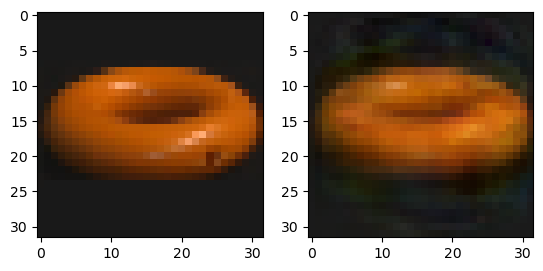

In [6]:
ae = AE(3*32*32)
ae.to(device)
ae.load_state_dict(torch.load('runs/AE/coil100/trained_autoencoder.pth'))

loader = DataLoader(image_loader("data/coil100_video_test.npy"), batch_size=1, shuffle=False)
with torch.inference_mode():
    for i, img in enumerate(loader):
        img = img.to(device)
        img = img.view(-1, 3*32*32)
        output = ae(img)
        output = output.view(-1, 3, 32, 32)
        output = output[0].permute(1,2,0).cpu().detach().numpy()
        #output = np.transpose(output, (1, 2, 0))
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img.view(3,32,32).permute(1,2,0).cpu().detach().numpy())
        ax[1].imshow(output)
        plt.show()
        # if i == 50:
        break

In [7]:
img_AE = []
with torch.no_grad():
    for i in range(len(image_list)):
        output = ae(image_list[i].reshape(-1, 3*32*32)).view(-1, 3, 32, 32)
        output = cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB)
        img_AE.append(output)
        # plt.imshow(cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB))
        # plt.show()
    #plt.imshow(image_list[0].squeeze().permute(1,2,0).cpu().detach().numpy())

In [8]:
image_list[0].squeeze().permute(1,2,0).shape

torch.Size([32, 32, 3])

In [9]:
vid_loader = DataLoader(mario_loader("data/coil100_video_test.npy"), batch_size=1, shuffle=False)

encode_list = []
with torch.inference_mode():
    for i, vid in enumerate(vid_loader):
        vid = vid.to(device)
        print(vid.shape)
        vid_encode = []
        for j in range(vid.shape[-1]):
            
            img = vid[0,:,:,:,j].to(torch.float32).to(device).view(-1, 3*32*32)
            output = ae.encoder(img)
            vid_encode.append(output.squeeze().cpu().detach().numpy())
        encode_list.append(np.array(vid_encode))
        

torch.Size([1, 3, 32, 32, 2200])


In [10]:
acc_AE, ari_AE = [], []
print("init\t\ttime\tinertia\tcompl\tARI\tss")
for i in range(1):
    result_AE = compute_scores(torch.from_numpy(encode_list[i].T[None,None,None,:,None,:]), 3, labels)
    acc_AE.append(result_AE[-3])
    ari_AE.append(result_AE[-2])
    
print('AE ACC:', np.mean(acc_AE))
print('AE ARI:', np.mean(ari_AE))

init		time	inertia	compl	ARI	ss
k-means++	0.076s	152	0.7774	0.4404	0.3693
AE ACC: 0.7773790975453606
AE ARI: 0.4403868126065015


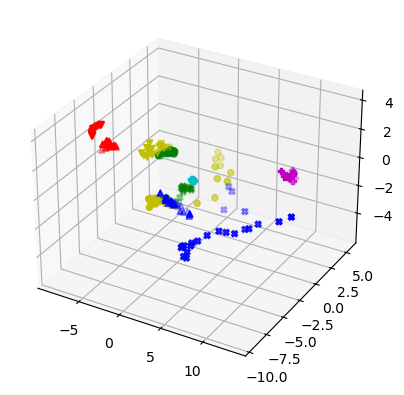

In [11]:
pca = PCA(n_components=3)
test = pca.fit_transform(encode_list[0])
ax = plt.figure().add_subplot(projection='3d')
#ax.scatter(test[:100,0], test[:100,1], test[:100,2], c='g', marker='o')
#ax.scatter(test[100:200,0], test[100:200,1], test[100:200,2], c='y', marker='o')
#ax.scatter(test[200:300,0], test[200:300,1], test[200:300,2], c='b', marker='o')
#ax.scatter(test[300:400,0], test[300:400,1], test[300:400,2], c='k', marker='o')
#ax.scatter(test[400:500,0], test[400:500,1], test[400:500,2], c='r', marker='o')

#ax.scatter(test[:22,0], test[:22,1], test[:22,2], c='g', marker='o')
#ax.scatter(test[22:22*2,0], test[22:22*2,1], test[22:22*2,2], c='b', marker='o')
#ax.scatter(test[22:22*2,0], test[22:22*2,1], test[22:22*2,2], c='b', marker='o')
#ax.scatter(test[22:22*2,0], test[22:22*2,1], test[22:22*2,2], c='b', marker='o')
#ax.scatter(test[22:22*2,0], test[22:22*2,1], test[22:22*2,2], c='b', marker='o')
#ax.scatter(test[22:22*2,0], test[22:22*2,1], test[22:22*2,2], c='b', marker='o')
#plt.show()


# scatter 20 classes
# need 20 different colors or shapes

import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['o', 's', 'v', '^', 'D', 'P', 'X']

class_combinations = [(color, marker) for color in colors for marker in markers]
np.random.shuffle(class_combinations)
class_combinations = class_combinations[:10]  # Select the first 20 combinations

for i, (color, marker) in enumerate(class_combinations):
    ax.scatter(test[i*22:i*22+22,0], test[i*22:i*22+22,1], test[i*22:i*22+22,2], c=color, marker=marker)

plt.show()
#for i in range(20):
#    ax = plt.figure().add_subplot(projection='3d')
#    # we need different colors for each class
#    ax.scatter(test[i*22:i*22+22,0], test[i*22:i*22+22,1], test[i*22:i*22+22,2], c='g', marker='o')
#    ax.scatter(test[i*22:i*22+22,0], test[i*22:i*22+22,1], test[i*22:i*22+22,2], c='g', marker='o')
#    plt.show()

# DPCN-Shrinkage

In [12]:
from utils.general import make_patches, patch_to_image

In [53]:
Shrinkage = MM_Layer(n_ch=3, lam=0., gamma0=.1, mu=0.001, beta=.1, n_u=50, multi_dict=True, state_size=2000,
                         cause_size=128, patch_size=16, n_x=1, use_A=False)
Shrinkage.to(device)
Shrinkage.load_state_dict(torch.load('runs/shrinkage/coil100/layer1_5.pth.tar'))
Shrinkage.eval()

MM_Layer()

In [49]:
test = torch.load('runs/shrinkage/coil100/layer1.pth.tar')
print(test.keys())
print(test['A'].shape, test['B'].shape, test['C'].shape)

odict_keys(['A', 'B', 'C', 'I_x', 'I_u', 'lam', 'gamma0', 'mu', 'beta'])
torch.Size([1, 3, 4, 2000, 2000]) torch.Size([1, 3, 1, 2000, 128]) torch.Size([1, 3, 4, 256, 2000])


In [35]:
img_Shrinkage = []
with torch.no_grad():
    for i in range(len(image_list)):
        #output = Shrinkage(image_list[i])
        #output = cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB)
        #img_Shrinkage.append(output)
        patches = make_patches(image_list[i], 16)
        x_t_minus_1=torch.randn_like(Shrinkage.C.transpose(-1,-2) @ patches)
        x,u = Shrinkage.AM(patches, x_t_minus_1)
        # x_t_minus_1 = torch.randn_like(X[:, :, :, :, :, 0])
        recon = Shrinkage.C @ x
        recon = patch_to_image(recon, 16)
        recon = recon[0].permute(1,2,0).cpu().detach().numpy()
        recon = cv2.cvtColor(recon, cv2.COLOR_BGR2RGB)
        img_Shrinkage.append(recon)
    # plt.imshow(cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB))
    # plt.show()
    #plt.imshow(image_list[0].squeeze().permute(1,2,0).cpu().detach().numpy())

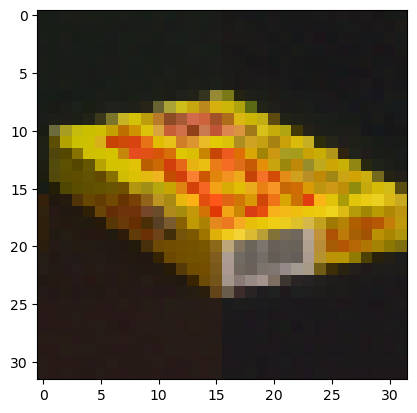

In [16]:
plt.imshow(img_Shrinkage[2].clip(0,1))

In [54]:
vid_loader = DataLoader(mario_loader("data/coil100_video_test.npy"), batch_size=1, shuffle=False)

acc_F, acc_S = [], []
ari_F, ari_S = [], []
spa_F, spa_S = [], []
with torch.no_grad():
    for _, data in enumerate(vid_loader):
        data = data.to(torch.float32).to(device)
        #X_F, U_F = FISTA.inference(data)
        start = time()
        X_S, U_S = Shrinkage.inference(data)
        print("inference time for one video:", time()-start)
        print("init\t\ttime\tinertia\tcompl\tARI\tss")
        #result_F = compute_scores(U_F, 2, labels)
        result_S = compute_scores(U_S, 2, labels)
        print()
        
        #acc_F.append(result_F[-3])
        acc_S.append(result_S[-3])
        
        #ari_F.append(result_F[-2])
        ari_S.append(result_S[-2])
        
        #spa_F.append(np.sum(U_F.cpu().numpy() == 0) / U_F.cpu().numpy().size)
        spa_S.append(np.sum(U_S.cpu().numpy() == 0) / U_S.cpu().numpy().size)
        
print("FISTA ACC:", np.mean(acc_F), "FISTA ARI:", np.mean(ari_F), "FISTA Sparsity:", np.mean(spa_F))
print("Shrinkage ACC:", np.mean(acc_S), "Shrinkage ARI:", np.mean(ari_S), "Shrinkage Sparsity:", np.mean(spa_S))

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
	 600 frame
	 700 frame
	 800 frame
	 900 frame
	 1000 frame
	 1100 frame
	 1200 frame
	 1300 frame
	 1400 frame
	 1500 frame
	 1600 frame
	 1700 frame
	 1800 frame
	 1900 frame
	 2000 frame
	 2100 frame
	 2200 frame
inference time for one video: 47.67890667915344
init		time	inertia	compl	ARI	ss
k-means++	0.032s	20	0.7276	0.3129	0.3312

FISTA ACC: nan FISTA ARI: nan FISTA Sparsity: nan
Shrinkage ACC: 0.7275731281859208 Shrinkage ARI: 0.31290218841525874 Shrinkage Sparsity: 0.05990767045454545


/home/UFAD/ding.chi/anaconda3/envs/universe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/UFAD/ding.chi/anaconda3/envs/universe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [55]:
compute_scores(X_S, 3, labels)

k-means++	0.030s	91	0.8340	0.4982	0.3332


['k-means++',
 0.030081987380981445,
 90.7747562224967,
 0.8339757644176564,
 0.4982059639883504,
 0.3331584483916141]

In [58]:
# calculate sparsity of X_S
print(np.sum(X_S.cpu().numpy() == 0) / X_S.cpu().numpy().size)

0.2755612689393939


In [59]:
# compute percentage of 0 values in X_S
print(np.sum(X_S.cpu().numpy() == 0) / X_S.cpu().numpy().size)

0.2755612689393939


# DPCN-FISTA

In [21]:
from utils.model import FISTA_Layer

In [22]:
layer1 = FISTA_Layer(n_ch=3, lam=0., gamma0=.1, mu=0.001, beta=0.1, X_dim=1000, U_dim=128, patch_size=16, 
                     input_size=40, isTopLayer=True, n_steps=50, n_dict=4)
layer1 = layer1.to(device)
layer1.device=device
layer1.load_state_dict(torch.load('runs/FISTA/coil100/layer1_vis_2.pth.tar'))

<All keys matched successfully>

In [28]:
torch.load('runs/FISTA/coil100/layer1_vis_2.pth.tar')['C'].shape

torch.Size([1, 3, 4, 256, 1000])

In [29]:
img_FISTA = []
with torch.no_grad():
    for i in range(len(image_list)):
        patches = make_patches(image_list[i], 16)
        
        # use zeros to initialize x_t_minus_1, so that the time sequence is turned off
        x_t_minus_1=torch.zeros_like(layer1.C.transpose(-1,-2) @ patches)
        x,u = layer1.AM_FISTA(patches, x_t_minus_1)
        # x_t_minus_1 = torch.randn_like(X[:, :, :, :, :, 0])
        recon = layer1.C @ x
        recon = patch_to_image(recon, 16)
        recon = recon[0].permute(1,2,0).cpu().detach().numpy()
        recon = cv2.cvtColor(recon, cv2.COLOR_BGR2RGB)
        img_FISTA.append(recon)
        #output = layer1(image_list[i])
        #output = cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB)
        #img_FISTA.append(output)
        
        # plt.imshow(cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB))
        # plt.show()
    #plt.imshow(image_list[0].squeeze().permute(1,2,0).cpu().detach().numpy())

In [17]:
vid_loader = DataLoader(mario_loader("data/coil100_video_test.npy"), batch_size=1, shuffle=False)

acc_F, acc_S = [], []
ari_F, ari_S = [], []
spa_F, spa_S = [], []

#F = FISTA_Layer(n_ch=3, lam=0.5, gamma0=1., mu=0.001, beta=0.2, X_dim=2000, U_dim=128, patch_size=16, 
#                     input_size=40, isTopLayer=True, n_steps=50, multi_dict=True)
F = FISTA_Layer(n_ch=3, lam=0., gamma0=.1, mu=0.001, beta=0.1, X_dim=1000, U_dim=128, patch_size=16, 
                     input_size=40, isTopLayer=True, n_steps=50, multi_dict=True)
F = F.to(device)
F.device=device
#F.load_state_dict(torch.load('runs/FISTA/coil100/layer1_5.pth.tar'))
F.load_state_dict(torch.load('runs/FISTA/coil100/layer1_vis_10.pth.tar'))

<All keys matched successfully>

In [18]:

with torch.no_grad():
    for _, data in enumerate(vid_loader):
        data = data.to(torch.float32).to(device)
        start = time()
        X_F, U_F = F.inference(data)
        print("inference time for one video:", time()-start)
        #X_S, U_S = Shrinkage.inference(data)
        
        print("init\t\ttime\tinertia\tcompl\tARI\tss")
        result_F = compute_scores(U_F, 2, labels)
        #result_S = compute_scores(U_S, 2, labels)
        print()
        
        acc_F.append(result_F[-3])
        #acc_S.append(result_S[-3])
        
        ari_F.append(result_F[-2])
        #ari_S.append(result_S[-2])
        
        spa_F.append(np.sum(U_F.cpu().numpy() == 0) / U_F.cpu().numpy().size)
        #spa_S.append(np.sum(U_S.cpu().numpy() == 0) / U_S.cpu().numpy().size)
        
print("FISTA ACC:", np.mean(acc_F), "FISTA ARI:", np.mean(ari_F), "FISTA Sparsity:", np.mean(spa_F))
#print("Shrinkage ACC:", np.mean(acc_S), "Shrinkage ARI:", np.mean(ari_S), "Shrinkage Sparsity:", np.mean(spa_S))

	 100 frame
	 200 frame
	 300 frame
	 400 frame
	 500 frame
	 600 frame
	 700 frame
	 800 frame
	 900 frame
	 1000 frame
	 1100 frame
	 1200 frame
	 1300 frame
	 1400 frame
	 1500 frame
	 1600 frame
	 1700 frame
	 1800 frame
	 1900 frame
	 2000 frame
	 2100 frame
	 2200 frame
inference time for one video: 225.13666820526123
init		time	inertia	compl	ARI	ss
k-means++	0.028s	13	0.8247	0.4304	0.4406

FISTA ACC: 0.8246769376423255 FISTA ARI: 0.4304481190039148 FISTA Sparsity: 0.0015669389204545454


In [172]:
# results for FISTA vis (without time transitioning)
compute_scores(X_F, 3, labels)

k-means++	4.789s	124	0.8193	0.4920	0.3786


['k-means++',
 4.788519620895386,
 123.70551163776919,
 0.8193091654125679,
 0.4919675267559289,
 0.3786160451223174]

In [44]:
# results for using FISTA with time transitioning
compute_scores(X_F, 3, labels)

k-means++	0.045s	136	0.8086	0.4669	0.4209


['k-means++',
 0.04500889778137207,
 136.2649441740565,
 0.8086344201721524,
 0.46693607022333766,
 0.42092541899241187]

In [36]:
# compute percentage of 0 values in X_S
print(np.sum(X_F.cpu().numpy() == 0) / X_F.cpu().numpy().size)

0.8102484090909091


# WTA-RNN-AE

In [34]:
wta_ae = WTA_RNN_AE(32*32*3, 10)
wta_ae.to(device)
wta_ae.load_state_dict(torch.load('runs/WTA_AE/coil100/trained_autoencoder.pth'))
vid_loader = DataLoader(mario_loader("data/coil100_video_test.npy"), batch_size=1, shuffle=False)


In [35]:
img_WTA = []

with torch.no_grad():
    for i in range(len(image_list)):
        output,_,_ = wta_ae(image_list[i].reshape(-1, 3*32*32))
        output = output.view(-1, 3, 32, 32)
        output = cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB)
        img_WTA.append(output)
        # plt.imshow(cv2.cvtColor(output[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB))
        # plt.show()

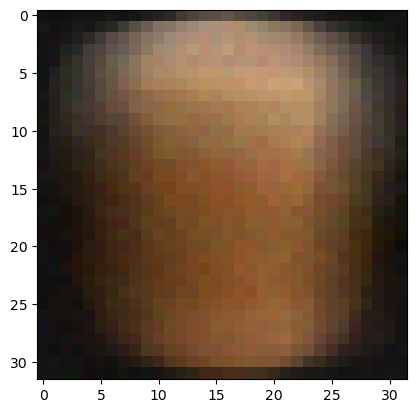

In [83]:
plt.imshow(img_WTA[12])

In [11]:
encode_list = []
with torch.inference_mode():
    for batch in vid_loader:
        batch = batch.to(torch.float32).to(device)
        video_encode = []
        for i in range(batch.shape[-1]):
            img_batch = batch[:, :, :, :, i].clone()
            # next_img_batch = batch[:, :, :, :, i+1].clone()
            if i == 0: h = None
            img_batch = img_batch.reshape(-1, 32*32*3)#.to(device)
            # Forward pass
            code = wta_ae.encoder(img_batch)
            video_encode.append(code.cpu().numpy())
        print(len(video_encode))
        encode_list.append(np.vstack(video_encode))

2200


In [12]:
batch.shape

torch.Size([1, 3, 32, 32, 2200])

In [13]:
acc_WTA_AE, ari_WTA_AE = [], []
print("init\t\ttime\tinertia\tcompl\tARI\tss")
for i in range(1):
    result_AE = compute_scores(torch.from_numpy(encode_list[i].T[None,None,None,:,None,:]), 3, labels)
    acc_WTA_AE.append(result_AE[-3])
    ari_WTA_AE.append(result_AE[-2])
    
print('WTA-AE ACC:', np.mean(acc_WTA_AE))
print('WTA-AE ARI:', np.mean(ari_WTA_AE))

init		time	inertia	compl	ARI	ss
k-means++	0.020s	129	0.7928	0.4445	0.3687
WTA-AE ACC: 0.79284823470914
WTA-AE ARI: 0.44446658586861715


In [32]:
import torchvision
def get_sequence(video):
    
    img_list = [torch.from_numpy(video[i]).permute(2,0,1).to(torch.float32) for i in range(15)]
    images = torch.stack(img_list)
    images = torchvision.utils.make_grid(images, nrow=15, padding=5, pad_value=1)
    images = images.permute(1,2,0).numpy()
    # images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    return images

In [38]:
img_gt = []
for i in range(len(image_list)):
    img = image_list[i]
    #output = img.view(-1, 3, 32, 32)
    output = cv2.cvtColor(img[0].permute(1,2,0).cpu().detach().numpy(), cv2.COLOR_BGR2RGB)
    img_gt.append(output)

In [39]:
len(img_gt)

15

In [40]:
images_AE = get_sequence(img_AE)
images_WTA = get_sequence(img_WTA)
images_Shrinkage = get_sequence(img_Shrinkage)
images_FISTA = get_sequence(img_FISTA)
images_gt = get_sequence(img_gt)

In [41]:
np.save('images_AE_C.npy', images_AE)
np.save('images_WTA_C.npy', images_WTA)
np.save('images_FISTA_C.npy', images_FISTA)
np.save('images_Shrinkage_C.npy', images_Shrinkage)
np.save('images_gt_C.npy', images_gt)

In [151]:
image_list[0].shape

torch.Size([1, 3, 32, 32])

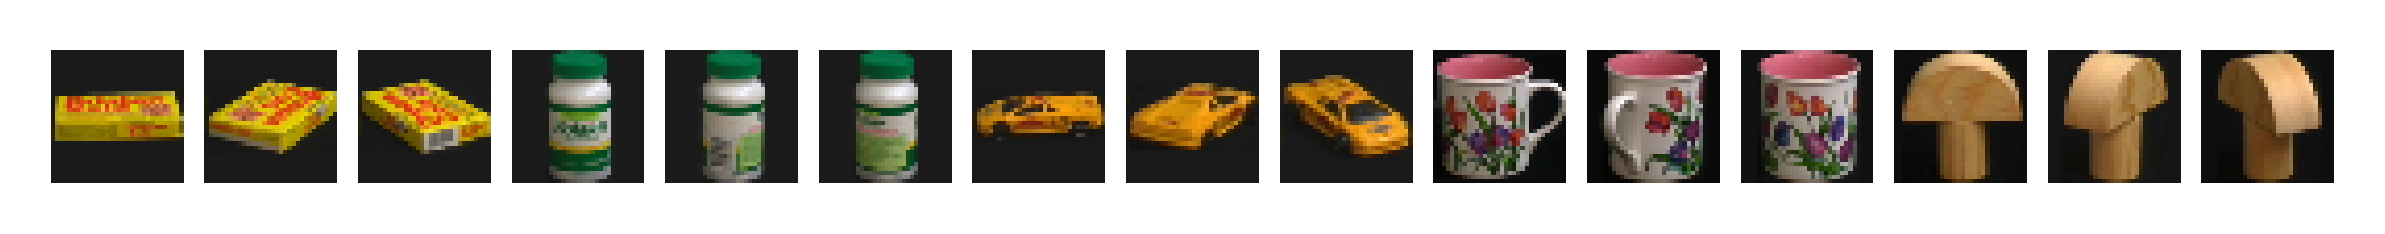

In [161]:
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_gt)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')

# save the images
plt.savefig('coil100_gt.pdf', format='pdf', dpi=300, bbox_inches='tight')

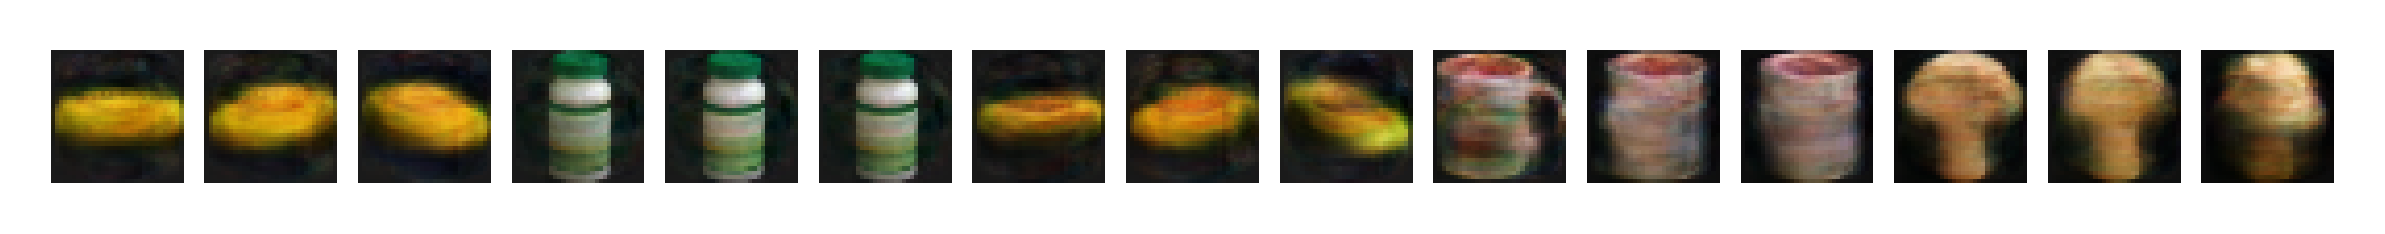

In [162]:
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_AE)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')

# save the images
plt.savefig('coil100_AE.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


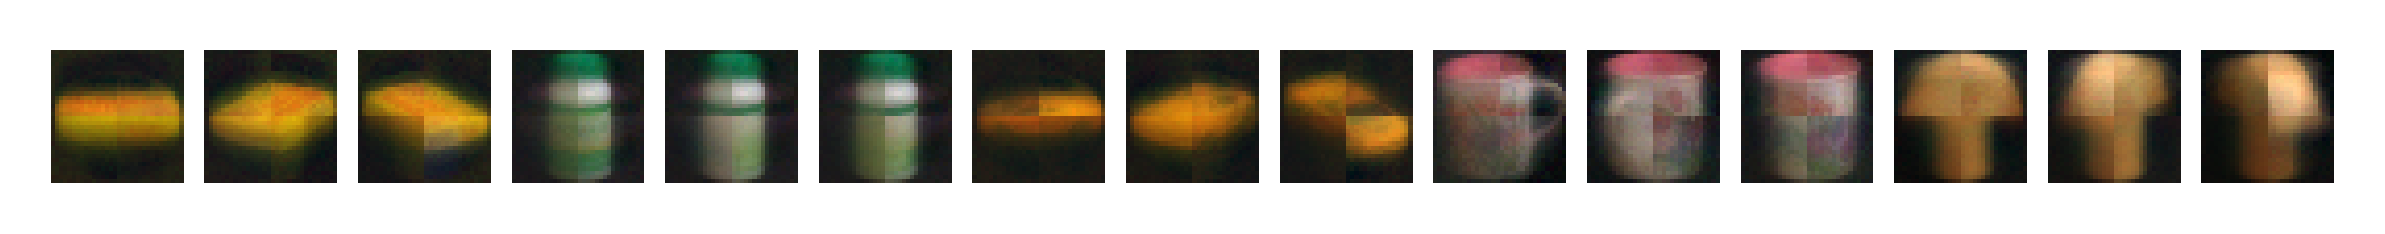

In [163]:
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_FISTA)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')

# save the images
#plt.savefig('coil100_FISTA.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 559.5, 41.5, -0.5)

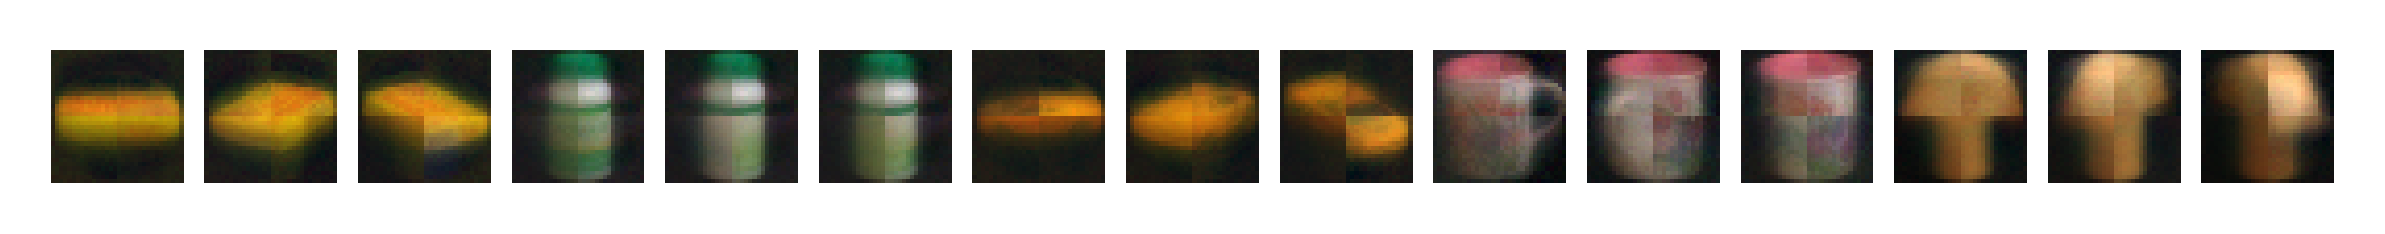

In [33]:
#plt.rcParams["font.serif"] = ["Times New Roman"]
images_FISTA = get_sequence(img_FISTA)
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_FISTA)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')

# save the images
#plt.savefig('coil100_FISTA.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


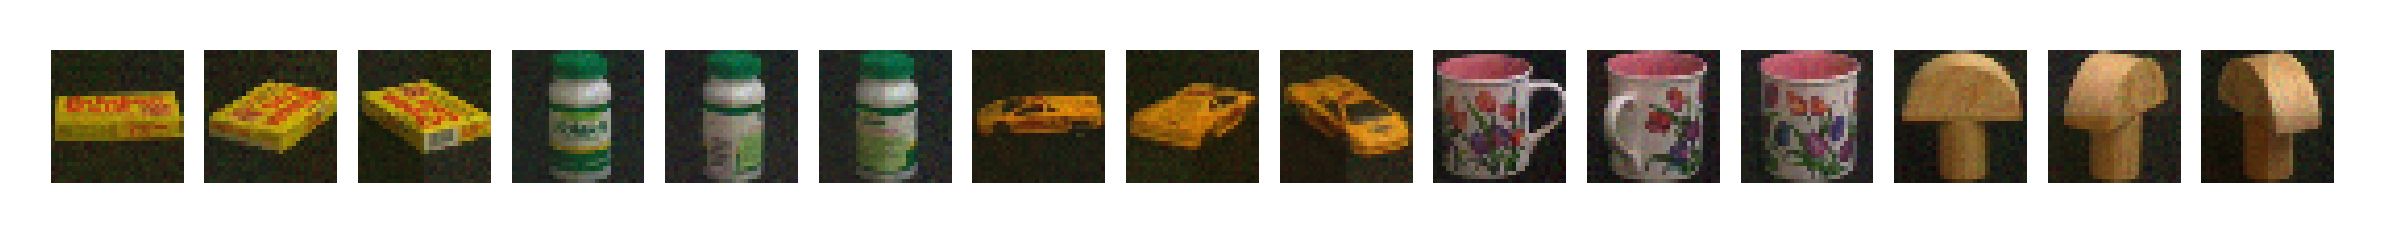

In [164]:
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_Shrinkage)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')

# save the images
plt.savefig('coil100_Shrinkage.pdf', format='pdf', dpi=300, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


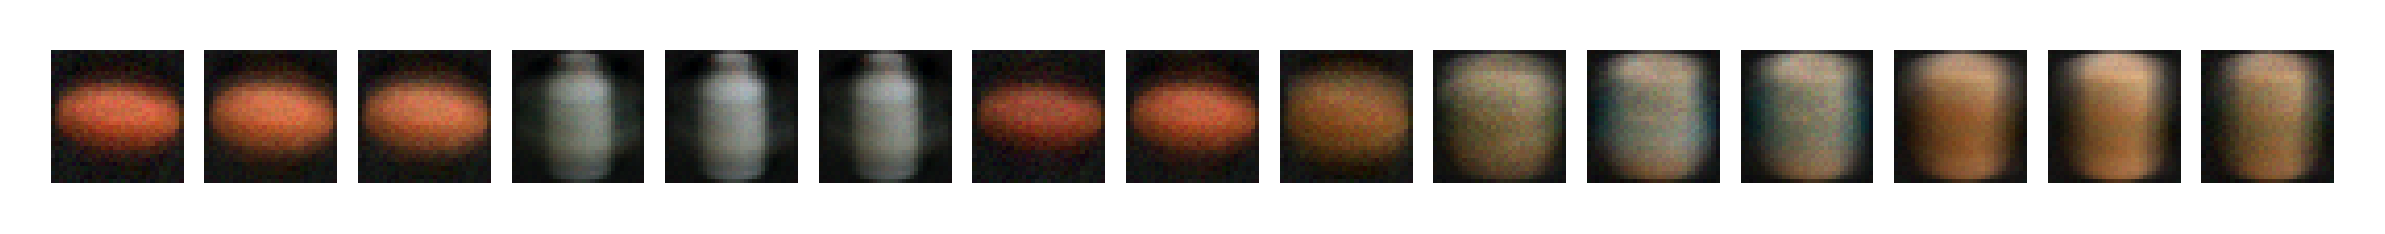

In [165]:
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(images_WTA)
#plt.ylabel('GT', fontsize=14)
plt.axis('off')

# save the images
plt.savefig('coil100_WTA.pdf', format='pdf', dpi=300, bbox_inches='tight')